I am referring: https://blog.keras.io/building-autoencoders-in-keras.html

Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model
from keras import backend as K
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from keras.callbacks import TensorBoard

# os.system(r'tensorboard --logdir=/tmp/autoencoder &')
model_save_path = r'../models/cnn_hitansh.h5'
source_size = 500

input_img = Input(shape=(source_size, source_size, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
W0707 15:57:48.595125 139773460092736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0707 15:57:48.610087 139773460092736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0707 15:57:48.613124 139773460092736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0707 15:57:48.625842 139773460092736 deprecation_wrapper.py:119] From /usr

To train it, we will use the original MNIST digits with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1.

In [2]:
# Data Preparation
# We are resizing the images as square, with padding

def resize_with_padding(image, desired_size = 500):
    im=image
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_im

x_train, x_test = [], []

PATH_TO_TEST_IMAGES_DIR = r'../data/train/XR_HAND_PHOTOSHOP/'
ALL_IMAGE_PATHS = []

for r, d, f in os.walk(PATH_TO_TEST_IMAGES_DIR):
    for file in f:
        if '.png' in file:
            # os.remove(os.path.join(r,file))
            ALL_IMAGE_PATHS.append(os.path.join(r, file))

# taking num_train images for training, num_test images for testing
num_train = 1000
num_test = 100

for i in ALL_IMAGE_PATHS[:num_train]:
    img = cv2.imread(i, 0)
    x_train.append(resize_with_padding(img, desired_size = source_size))

for i in ALL_IMAGE_PATHS[num_train:num_train + num_test]:
    img = cv2.imread(i, 0)
    x_test.append(resize_with_padding(img, desired_size = source_size))

x_train = np.reshape(x_train, (len(x_train), source_size, source_size, 1))
x_test = np.reshape(x_test, (len(x_test), source_size, source_size, 1))
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [3]:
print(x_train.shape)
print(x_test.shape)

(1000, 500, 500, 1)
(100, 500, 500, 1)


Let's train this model for 50 epochs. For the sake of demonstrating how to visualize the results of a model during training, we will be using the TensorFlow backend and the TensorBoard callback.

First, let's open up a terminal and start a TensorBoard server that will read logs stored at /tmp/autoencoder.

In [4]:
f = open(r'../../log.txt', 'w')

Then let's train our model. In the callbacks list we pass an instance of the TensorBoard callback. After every epoch, this callback will write logs to /tmp/autoencoder, which can be read by our TensorBoard server.

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=10,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

autoencoder.save(model_save_path)
f.write('Model has been saved')
f.close()

W0705 16:17:47.208347 139779357112128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0705 16:17:47.210284 139779357112128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Train on 1000 samples, validate on 100 samples
Epoch 1/100
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3083 - val_loss: 0.1453
Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1456 - val_loss: 0.1461
Epoch 3/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1441 - val_loss: 0.1439
Epoch 4/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1434 - val_loss: 0.1428
Epoch 5/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1429 - val_loss: 0.1427
Epoch 6/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1426 - val_loss: 0.1436
Epoch 7/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1428 - val_loss: 0.1427
Epoch 8/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1426 - val_loss: 0.1429
Epoch 9/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1424 - val_loss: 0.1434
Epoch 10/100
1000/1000 [==

In [5]:
autoencoder = load_model(model_save_path)

W0707 15:58:25.308583 139773460092736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



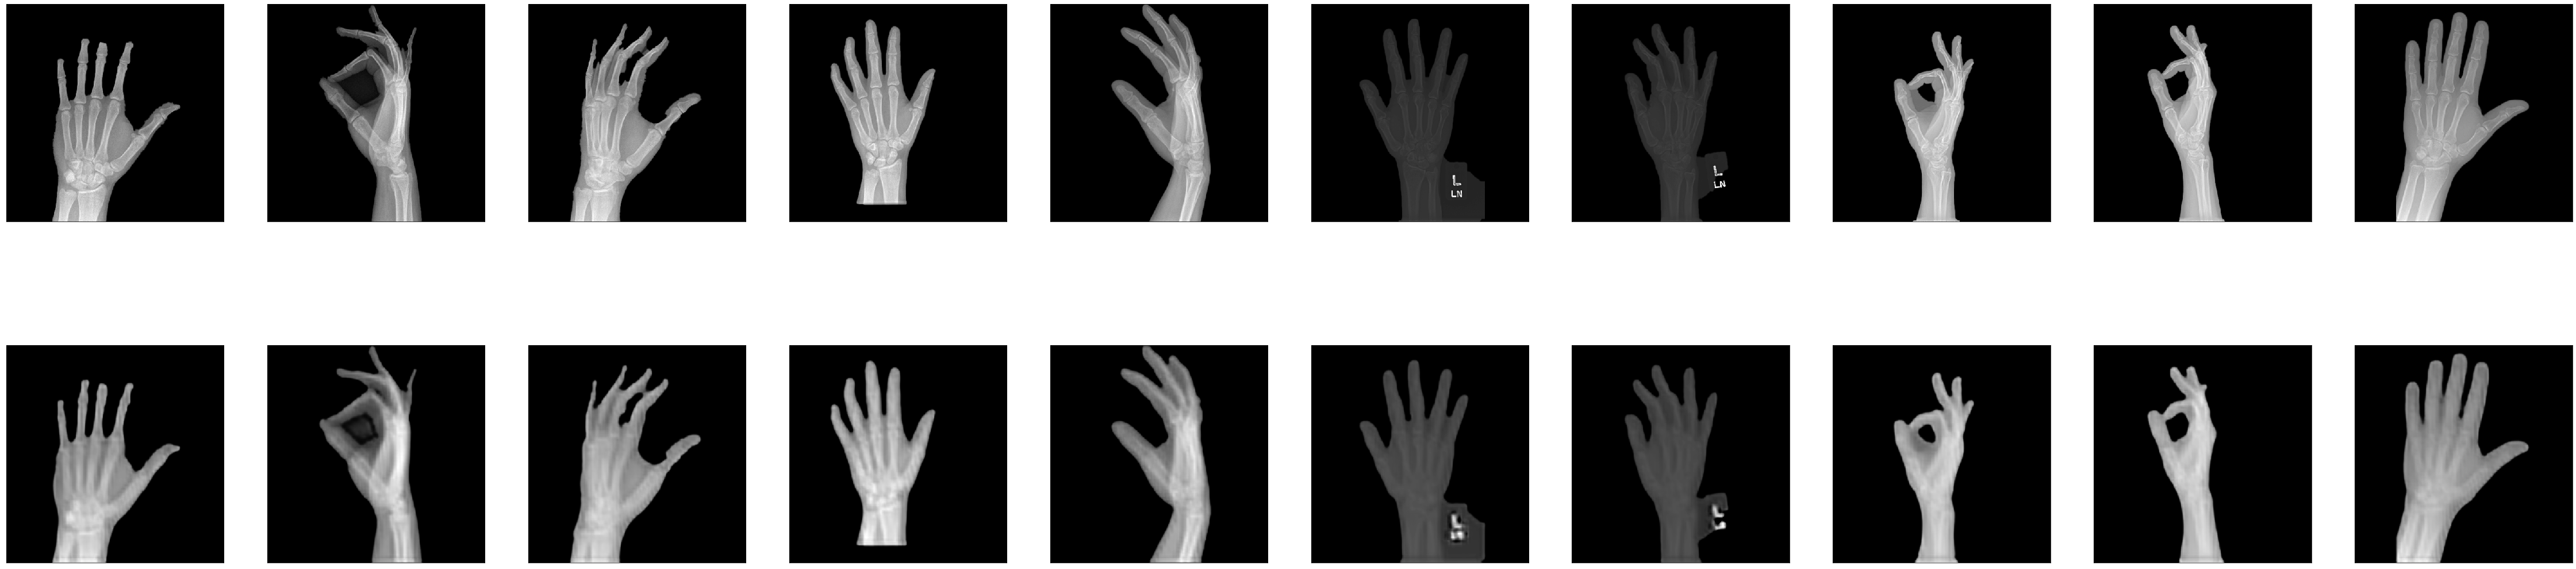

In [6]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(80, 20))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(source_size, source_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(source_size, source_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We can also have a look at the 128-dimensional encoded representations. These representations are 8x63x63, so we reshape them in order to be able to display them as grayscale images.

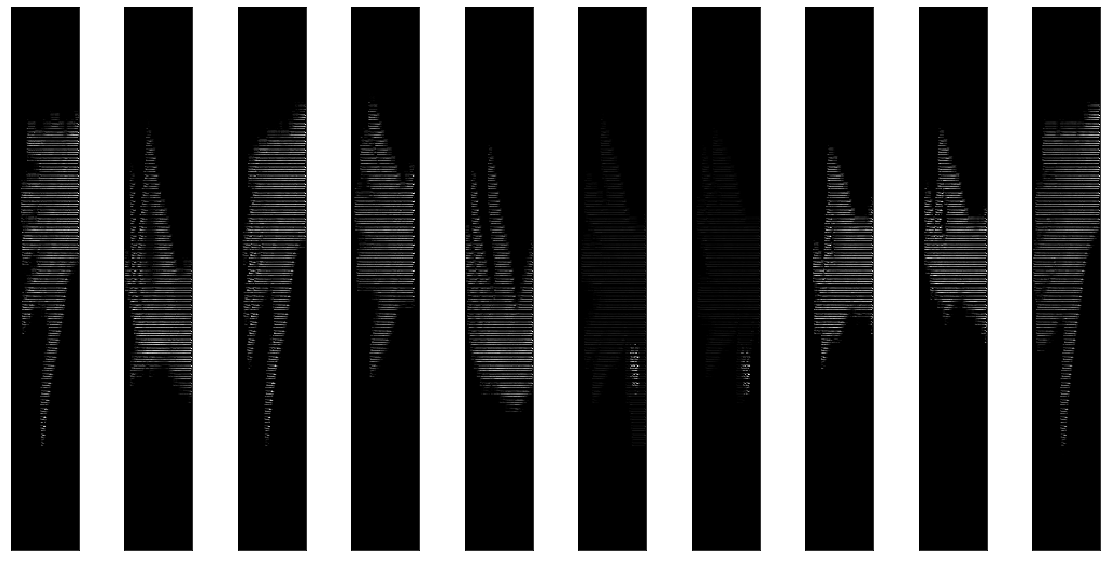

In [18]:
#Model = load_model(r'../models/cnn_hitansh.h5')

encoder = Model(input_img, encoded)

encoded_imgs = encoder.predict(x_test)

encoded_shape = encoded_imgs[0].shape

n = 10
plt.figure(figsize=(20, 10))
for i in range(1,n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(encoded_shape[0], encoded_shape[1] * encoded_shape[2]).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

<h3>DBScan on encoded representation</h3>

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

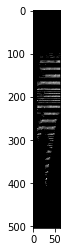

In [21]:
from sklearn.cluster import DBSCAN
a=encoded_imgs[1].reshape(encoded_shape[0], encoded_shape[1] * encoded_shape[2]).T
plt.imshow(a)
clustering = DBSCAN(eps=1000, min_samples=2).fit(a)
print(clustering.labels_)

<i>As we can see above, dbscan fails to detect any anomaly on the encoded representation</i>
<br>
Lets implement that using one class svm
<br>
<h3>One class svm on encoded representation</h3>

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1  1 -1  1 -1  1  1  1  1  1 -1  1 -1  1  1  1  1  1 -1
  1 -1  1  1  1  1  1 -1  1  1  1  1  1  1  1 -1  1 -1  1  1  1  1  1 -1
  1 -1  1  1  1  1  1 -1  1 -1  1  1  1  1 -1 -1  1 -1  1  1  1  1  1 -1
  1 -1  1  1  1  1  1 -1  1 -1  1  1  1  1  1 -1  1 -1  1  1  1  1  1 -1
  1 -1  1  1  1  1  1 -1  1 -1  1  1  1  1  1 -1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1 -1
  1 -1  1  1  1  1  1 -1  1 -1  1  1  1  1  1 -1  1 -1  1  1  1  1  1 -1
  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

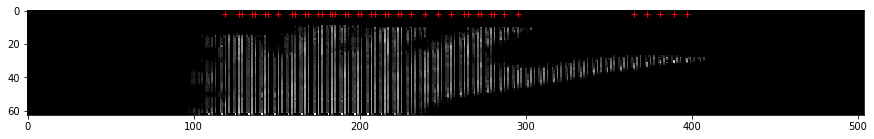

In [24]:
from sklearn import svm
outliers_fraction = 0.15
algorithm = svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)
labels=algorithm.fit_predict(a)
print(labels)

plt.figure(figsize=(15,5))

a=encoded_imgs[1].reshape(encoded_shape[0], encoded_shape[1] * encoded_shape[2]).T

plt.imshow(a.transpose())
pos=-1
h_positions=[]
for i in labels:
    pos+=1
    if i==-1:
        h_positions.append(pos)
h_x=[2 for i in range(len(h_positions))]
plt.plot(h_positions,h_x,'r+')

<i>We can see that OneClassSVM was able to identify some anomalies, seen by red pluses.</i>
<br>
However, that does not seem to make any sense too.
Lets now try <i>OneClassSVM on NMF</i> (non negative matrix factorisation H and W matrices).

<i>I am skipping the dbscan, because it is already implemented in one of the py file in features folder.</i>

<h3>One Class SVM using NMF</h3>

This is a result of W*H


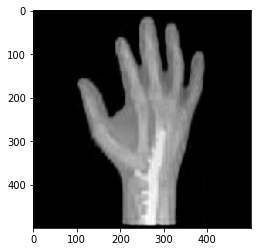

In [28]:
from sklearn import svm
from sklearn import decomposition

b=decoded_imgs[96].reshape(source_size, source_size)
outliers_fraction = 0.15
algorithm = svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)

n_components = 50
estimator = decomposition.NMF(n_components = n_components, init = 'random', tol=5e-3)    
W = estimator.fit_transform(b)
H = estimator.components_

new_img = np.dot(W,H)
#print(new_img.shape)
print('This is a result of W*H')
plt.imshow(new_img)

Applying oc-svm on H

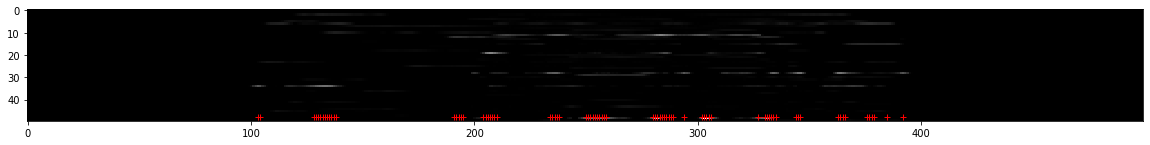

In [29]:
plt.figure(1,figsize=(20,40))
plt.imshow(H)

h=H.transpose()
y=[]
for i in range(h.shape[0]):
    y.append(sum(h[i][2:48]))

algorithm = svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.001)
labels=algorithm.fit_predict(H.transpose())

pos=-1
h_positions=[]
for i in labels:
    pos+=1
    if i==-1:
        h_positions.append(pos)
#print(h_positions)
h_x=[n_components-2 for i in range(len(h_positions))]
plt.plot(h_positions,h_x,'r+')

Applying oc-svm on W

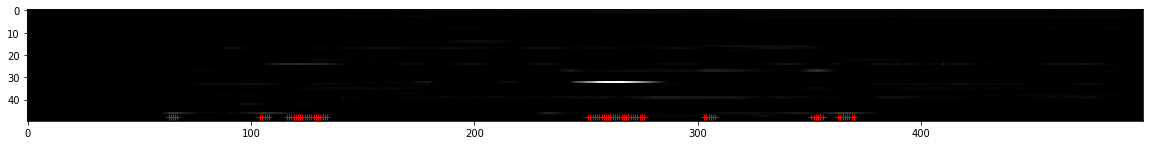

In [30]:
plt.figure(1,figsize=(20,40))
plt.imshow(W.transpose())
y=[]
for i in range(W.shape[0]):
    y.append(sum(W[i]))

algorithm = svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.001)
labels=algorithm.fit_predict(W)

pos=-1
w_positions=[]
for i in labels:
    pos+=1
    if i==-1:
        w_positions.append(pos)
w_x=[n_components-2 for i in range(len(w_positions))]
plt.plot(w_positions,w_x,'r+')

Lets combine the result.

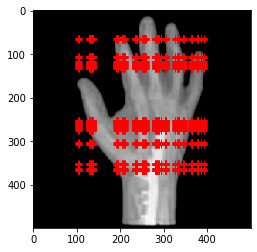

In [31]:
x_values=[]
y_values=[]
for i in h_positions:
    for j in w_positions:
        x_values.append(i)
        new_img[j][i]=255
        y_values.append(j)
plt.plot(x_values,y_values,'r+')
plt.imshow(b)

We can reiterate it on another images too.